In [38]:
import pandas as pd
import re
from scipy.stats import chisquare
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [12]:
df = pd.read_csv('/Users/zhangshuyi/Desktop/main_trials.csv')
print(list(df.columns))
df.head()

['Participant ID', 'Display', 'Spreadsheet: Product', 'Response', 'Position', 'Reaction Time', 'Deal Type', 'Likely to buy', 'Confident in choice', 'Likely to change', 'Attention Check Response', 'Why Response']


,Participant ID,Display,Spreadsheet: Product,Response,Position,Reaction Time,Deal Type,Likely to buy,Confident in choice,Likely to change,Attention Check Response,Why Response
0,13397659,3 Discounts Main,Tablet Case.png,$25 (Deal: 10% off),Position 1,18598.5,Percentage off,3,1,7,3,"It's all the same, but 10% looks bigger."
1,13397659,3 Discounts Main,Phone Charger.png,$15 (Deal: 10% off),Position 3,6847.8,Percentage off,1,5,7,3,All the same price so I chose the cheapest
2,13397659,4 Discounts Main,DSLR Lens.png,$960 (Deal: buy 1 get 1 free),Position 1,13848.7,BOGO,2,5,6,4,It saves more so I can sell the duplicate one
3,13397659,4 Discounts Main,Sofa.png,$1000 (Deal: $200 off),Position 3,13065.3,Dollar off,2,5,6,4,Too big so I can't store it and sell it.
4,13397659,2 Discounts Main,Skincare Kit.png,$90 (Deal: 15% off),Position 1,14565.8,Percentage off,5,6,6,2,15 looks bigger though they are all the same


In [ ]:
# Step 2: Filter to monetarily equivalent trials
if 'equivalent_trial' in df.columns:
    df_equiv = df[df['equivalent_trial'] == 1].copy()
else:
    # If no such column, just show all and refine later
    df_equiv = df.copy()

In [13]:
df['base_price'] = (
    df['Response']                       # "$25 (Deal: 10% off)"
      .str.extract(r'\$(\d+(?:\.\d+)?)') # -> "25"
      .astype(float)
)

In [17]:
df['deal_type'] = (
    df['Deal Type']
      .str.strip()
      .str.lower()
      .str.replace(' ', '_')             # "Dollar off" -> "dollar_off"
)

In [ ]:
# All data in main trials have monetarily equivalent discounts

In [28]:
df['price_bin'] = pd.qcut(df['base_price'], q=3, labels=['Low', 'Medium', 'High'])

In [ ]:
# Count how often each deal type is chosen by price level
counts = df.groupby(['price_bin', 'deal_type']).size().reset_index(name='count')

/var/folders/qf/_z697sgn3jx3215w7ykp1p1r0000gn/T/ipykernel_45911/573705727.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(['price_bin', 'deal_type']).size().reset_index(name='count')


In [ ]:
# Total choices per bin
totals = counts.groupby('price_bin')['count'].sum().reset_index(name='total')

/var/folders/qf/_z697sgn3jx3215w7ykp1p1r0000gn/T/ipykernel_45911/3209023202.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  totals = counts.groupby('price_bin')['count'].sum().reset_index(name='total')


In [31]:
# Merge totals to compute proportions
counts = counts.merge(totals, on='price_bin')
counts['proportion'] = counts['count'] / counts['total']

In [32]:
# Extract dollar-off proportions only
dollar_off_prop = counts[counts['deal_type'] == 'dollar_off']

In [34]:
print("Proportion of dollar_off choices by price level:\n")
print(dollar_off_prop[['price_bin', 'proportion']], '\n')

Proportion of dollar_off choices by price level:

  price_bin  proportion
1       Low    0.000000
5    Medium    0.341463
9      High    0.138889 



In [35]:
# Chi-square test: is dollar_off chosen more than expected by chance?
print("Chi-square tests for dollar_off overrepresentation by price level:\n")
for level in counts['price_bin'].unique():
    subset = counts[counts['price_bin'] == level]
    observed = subset['count'].values
    expected = [subset['total'].iloc[0] / len(subset)] * len(subset)  # equal expected frequencies
    chi2, p = chisquare(f_obs=observed, f_exp=expected)
    print(f"{level} → Chi2 = {chi2:.2f}, p = {p:.4f}")
    if p < 0.05:
        print("Significant: deal type preference present.\n")
    else:
        print("Not significant.\n")

Chi-square tests for dollar_off overrepresentation by price level:

Low → Chi2 = 63.51, p = 0.0000
Significant: deal type preference present.

Medium → Chi2 = 27.78, p = 0.0000
Significant: deal type preference present.

High → Chi2 = 10.67, p = 0.0137
Significant: deal type preference present.



/var/folders/qf/_z697sgn3jx3215w7ykp1p1r0000gn/T/ipykernel_45911/782911347.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


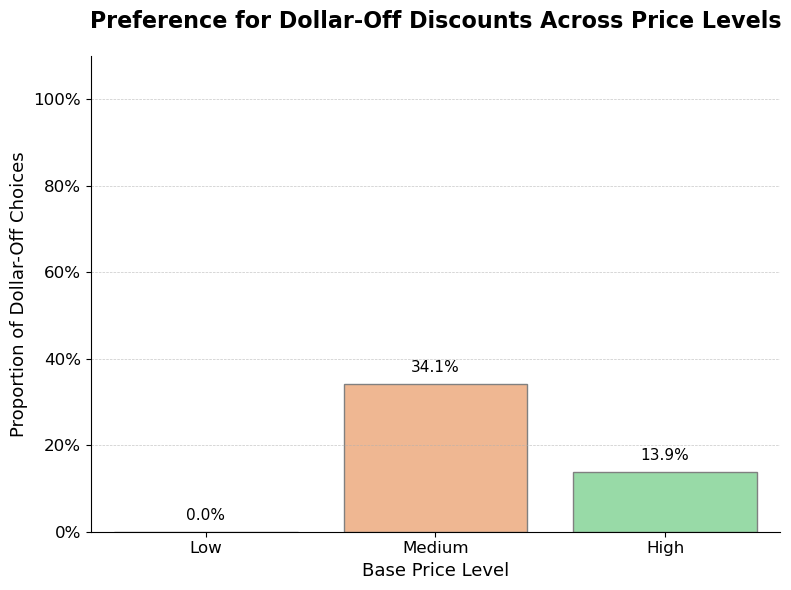

In [41]:
plt.figure(figsize=(8, 6))

ax = sns.barplot(
    data=dollar_off_prop,
    x='price_bin',
    y='proportion',
    palette='pastel',
    edgecolor='gray'
)

for patch in ax.patches:
    height = patch.get_height()
    x = patch.get_x() + patch.get_width() / 2
    ax.text(
        x=x,
        y=height + 0.02,
        s=f"{height * 100:.1f}%",
        ha='center',
        va='bottom',
        fontsize=11,
        fontweight='medium'
    )

plt.title('Preference for Dollar-Off Discounts Across Price Levels',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Base Price Level', fontsize=13)
plt.ylabel('Proportion of Dollar-Off Choices', fontsize=13)
plt.ylim(0, 1.1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
sns.despine()
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
